# Implémenter un algorithme de machine learning pour référencer des indicateurs de santé

#### Objectif
La Direction de la recherche, des études, de l’évaluation et des statistiques (DREES) dispose d'une liste importante d'indicateurs de la santé associés à leurs producteurs. Pour aider les utilisateurs à se repérer dans cette galaxie d'indicateurs, elle souhaite leur attribuer des "tags" créés par des experts du domaine de la santé. Parmi ceux-ci, 600 environ ont été manuellement référencés. La base complète étant constituée de 15000 indicateurs, il semble déraisonnable de procéder de manière non-automatique pour le reste de la base. L'objectif est d'implémenter un algorithme de machine learning pour imputer aux indicateurs restants leur tags.


##### Difficultés techniques

1) Il s'agit d'un sujet d'analyse textuelle, il nous faudra traiter le texte. Nous passerons tous les mots en minuscules, nous supprimerons les mots trop fréquents (de, une, à ...) et nous raciniserons pour éviter de considérer des mots très proches comme différents. Nous aurons à supprimer les nombres présents dans la base, mais nous souhaitons garder tout de même les tranches d'âges ("de 15 à 25 ans" par exemple) que nous aurons normalisé au préalable ("de 15 à 25 ans"="15-25ans"="15 à 25ans").

2) Certains tags prennent très souvent la valeur '1' quand d'autres sont très peu employés. Il est nécessaire de repérer ces derniers, comme nous le verrons en conclusion. Par ailleurs, il faut éliminer au préalable le tag qui ne prend que la valeur 0 dans toute la base.

3) De même nous éviterons un découpage entre train et test purement aléatoire. Nous veillerons à représenter correctement les tags rares. Autrement une division 80/20 de la base nous conduira à avoir des tags ne prenant jamais la valeur "1". Nous commencerons donc par récupérer une proportion de ces tags rares pour le train, et nous sélectionnerons ensuite aléatoirement dans le reste de la base.

4) Plusieurs solutions s'offrent à nous en matière de modélisation. Nous testerons plusieurs modèles et nous comparerons leurs performances. Cela demande de s'entendre sur ce qu'est un modèle "performant". Comme il peut être constaté à la lecture, un parti a été pris ici, celui de regarder quel modèle donnait la moyenne des bonnes prédictions sur les prédictions totales, entre tous les indicateurs. D'autres choix auraient pu être faits, par exemple, nous aurions pu choisir de mettre en avant les bonnes prédictions de 1 uniquement, en fonction de l'usage qui voudra être fait de ces modèles. Nous discuterons rapidement ces choix.

#### Plan :

###### Partie 1 : Apperçu des données et traitement du texte
    - Passage en minuscules
    - Mise en évidence de tags rares, traitement de ceux-ci, découpage entre train et test, en veillant à la répartition des tags rares
    - Suppression des mots les plus fréquents et racinisation
    - Binarisation des variables supplémentaires (nature de producteur...) pour traiter  pleinement toute l'information
    - Création de la matrice documents-termes
###### Partie 2 : Mise en place des modèles
    - Plusieurs modèles : 1) k-SVC 2) decision Tree 3) régression logistique pénalisée 4) random forest
    - Choix du meilleur modèle (random forest, régression logistique)
    - Matrices de confusions résultant du meilleur modèle
    - Conclusion (bonne prévision globale, difficultés avec la prévision des tags rares, suggestions)


# Partie 1 : Apperçu des données et traitement du texte

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.width', 200)
base = pd.read_excel('/Users/joe/Desktop/modélisation statistique/data.xls',sep = 't')
base.head()

,Indicateur,Classement producteur niv 3,Classement producteur niv 2,Classement producteur niv 1,Source,Producteur,Base,Producteur de la base,Population_generale,Personnes_agees,...,Droits_d_usagers_democratie_sanitaire,Mesures_d_inegalites_et_de_disparites_territoriales_de_sante,Contexte_demographique_et_socio_economique,Offre_de_soins,Offre_medico_sociale,Recours_aux_soins,Protection_sociale,Depenses_de_sante,Etat_de_sante,index
0,Montants infra-annuels de remboursement de la ...,Dépenses mensuelles en date de remboursement,Dépenses en date de remboursement - Séries lab...,Dépenses d'assurance maladie,SNIIRAM,CNAMTS,AMELI,Assurance maladie,1,0,...,0,0,0,0,0,1,0,1,0,65
1,Taux d'évolution PCAP des versements du TOTAL ...,Dépenses mensuelles en date de remboursement,Dépenses en date de remboursement - Séries lab...,Dépenses d'assurance maladie,SNIIRAM,CNAMTS,AMELI,Assurance maladie,1,0,...,0,0,0,0,0,1,0,1,0,108
2,Montants infra-annuels de remboursement d'hono...,Dépenses mensuelles par type de risque,Dépenses par type de risque,Dépenses d'assurance maladie,SNIIRAM,CNAMTS,AMELI,Assurance maladie,1,0,...,0,0,0,0,0,1,0,1,0,156
3,Montants infra-annuels de versement des Autre...,Dépenses mensuelles par type de risque,Dépenses par type de risque,Dépenses d'assurance maladie,SNIIRAM,CNAMTS,AMELI,Assurance maladie,1,0,...,0,0,0,0,0,1,0,1,0,196
4,Montants infra-annuels du total DES DÉPENSES A...,Dépenses mensuelles par type de risque,Dépenses par type de risque,Dépenses d'assurance maladie,SNIIRAM,CNAMTS,AMELI,Assurance maladie,1,0,...,0,0,0,0,0,0,0,1,0,207


#### On fait un certain nombre de transformations :
1) on enlève la poncutation, et on modifie les expressions avec des tranches d'âge pour pouvoir les garder et enlever les autres chiffres et on enlève les chiffres

2) on passe toutes les majuscules en minuscules 


1) on enlève la poncutation, et on modifie les expressions avec des tranches d'âge pour pouvoir les garder et enlever les autres chiffres et on enlève les chiffres

La difficulté est de trouver un moyen d'éliminer tous les chiffres sauf ceux indiquant des tranches d'âge: on fait en sorte que celles-ci soient sous la forme chiffres+ans (par exemple 15 à 25 ans devriendrait 1525ans), de façon a ensuite pouvoir éliminer de façon automatique les chiffres restant

In [3]:
import re
redundant = [',','.','(',')','-','\d+[a-z]',"\d+[A-Z]",'\d+\-']
base['Indicateur']=base['Indicateur'].str.lower()
for item in redundant:
    base['Indicateur']=base['Indicateur'].str.replace(item," ")
base['Indicateur'] = base['Indicateur'].str.replace("moins de ","-")
base['Indicateur'] = base['Indicateur'].str.replace(" à ","")
base['Indicateur'] = base['Indicateur'].str.replace(" an","an")
base['Indicateur'] = base['Indicateur'].str.replace(' ans ou plus','+')
base['Indicateur'] = base['Indicateur'].str.replace(' ans et moins','-ans')

#for item in base['Indicateur'].values:
    #print(re.compile("\d+.").search(base["Indicateur"].values))
    

In [4]:
redundant = ['\d+ ','\d+$']
base['Indicateur']=base['Indicateur'].str.lower()
for item in redundant:
    base['Indicateur']=base['Indicateur'].str.replace(item," ")

2) on passe toutes les majuscules en minuscules

In [5]:
for i in range(0,7+1):
    base.iloc[:, i]=base.iloc[:, i].str.lower()
base.columns=[x.lower() for x in base.columns]
base.head()

,indicateur,classement producteur niv 3,classement producteur niv 2,classement producteur niv 1,source,producteur,base,producteur de la base,population_generale,personnes_agees,...,droits_d_usagers_democratie_sanitaire,mesures_d_inegalites_et_de_disparites_territoriales_de_sante,contexte_demographique_et_socio_economique,offre_de_soins,offre_medico_sociale,recours_aux_soins,protection_sociale,depenses_de_sante,etat_de_sante,index
0,montants infraannuels de remboursement de la p...,dépenses mensuelles en date de remboursement,dépenses en date de remboursement - séries lab...,dépenses d'assurance maladie,sniiram,cnamts,ameli,assurance maladie,1,0,...,0,0,0,0,0,1,0,1,0,65
1,taux d'évolution pcap des versements du total ...,dépenses mensuelles en date de remboursement,dépenses en date de remboursement - séries lab...,dépenses d'assurance maladie,sniiram,cnamts,ameli,assurance maladie,1,0,...,0,0,0,0,0,1,0,1,0,108
2,montants infraannuels de remboursement d'honor...,dépenses mensuelles par type de risque,dépenses par type de risque,dépenses d'assurance maladie,sniiram,cnamts,ameli,assurance maladie,1,0,...,0,0,0,0,0,1,0,1,0,156
3,montants infraannuels de versement des autres...,dépenses mensuelles par type de risque,dépenses par type de risque,dépenses d'assurance maladie,sniiram,cnamts,ameli,assurance maladie,1,0,...,0,0,0,0,0,1,0,1,0,196
4,montants infraannuels du total des dépenses am...,dépenses mensuelles par type de risque,dépenses par type de risque,dépenses d'assurance maladie,sniiram,cnamts,ameli,assurance maladie,1,0,...,0,0,0,0,0,0,0,1,0,207


#### On souhaite avoir une idée du nombre de "1" par tag

On crée une series pour connaître le nombre de "1" par label et repérer les labels avec peu de 1 (beaucoup de 0)

In [6]:
base_new = base[[x for x in base.columns[8:-1]]]
count = base_new.apply(pd.Series.value_counts)
print(count.loc[1].fillna(0).sort_values())

e_sante__systemes_d_information_de_sante__telesante__telemedecine_                     0.0
population_precaire                                                                    7.0
qualite_et_securite_des_soins                                                          7.0
maladie_de_l_appareil_genito_urinaire__dont_les_insuffisances_renales_chroniques_      7.0
maladies_respiratoires_                                                                7.0
personnes_handicapees                                                                  8.0
droits_d_usagers_democratie_sanitaire                                                  8.0
diabete_et_autres_maladies_endocriniennes                                              9.0
personnes_agees                                                                       10.0
offre_medico_sociale                                                                  10.0
coordination_continuite                                                               11.0

On constate qu'un tag n'est jamais coché, on ne pourra pas le prédire, on le supprime de la base

In [7]:
base_new=base_new.drop(['e_sante__systemes_d_information_de_sante__telesante__telemedecine_'], axis=1)
count = base_new.apply(pd.Series.value_counts)
tags_effectifs=count.loc[1].fillna(0).sort_values()
print(tags_effectifs)

population_precaire                                                                    7
maladie_de_l_appareil_genito_urinaire__dont_les_insuffisances_renales_chroniques_      7
qualite_et_securite_des_soins                                                          7
maladies_respiratoires_                                                                7
personnes_handicapees                                                                  8
droits_d_usagers_democratie_sanitaire                                                  8
diabete_et_autres_maladies_endocriniennes                                              9
personnes_agees                                                                       10
offre_medico_sociale                                                                  10
maladies_neurologiques_ou_degeneratives                                               11
coordination_continuite                                                               11
pathologies_du_system

On voit que certains tags sont très rarement cochés. Par exemple, il n'y a que 7 indicateurs pour lesquels on a coché "population précaire". Si on fait un split entre le train et le test naïf, de manière purement aléatoire, on risque de perdre tous les 1 pour certains indicateurs, de sorte que certains tags dans la base de train seront des colonnes de 0 et ne prendront jamais la valeur 1. A ce moment, on ne pourra pas prédire les "1". Plutôt que de sélectionner aléatoirement la base de train, on va s'assurer d'avoir quelques 1 pour chaque tag. On complète ensuite la base de train avec le reste des observations qu'on sélectionne aléatoirement. 

Notons qu'à ce stade, il y aura de nombreuses transformations à faire sur la base de données, et il faudra aussi créer la matrice documents-termes. Ce que l'on crée ici, ce n'est pas vraiment la base de train ou de test, mais deux Series de "True" et de "False", "True" signifiant "je garde cette observation", et "False" "je ne prends pas cette observation". Par exemple dans condition_train, si la  4ème observation a un "True", alors on prend la 4ème observation dans le groupe de train. Ainsi, il suffit, après transformation de la matrice de documents-termes, d'écrire matrice_documents_termes[condition_train] pour avoir notre groupe de train.

### Création de deux series de True et de False pour construire une base de train et une base de test telles que la base de train contienne un certain nombre d'observations pour des tags plus rares

In [8]:
# On récupère la liste des tags qui apparaissent moins de 16 fois
tags_rares=tags_effectifs[tags_effectifs<=16].index.values.tolist()

L'objectif est de faire un split en train et en test qui soit prudent, dans le sens où l'on veut toujours garder des observations avec des tags assez rares pour les deux bases. Pour cela, on va créer d'abord un dictionnaire dans lequel on associe à chaque tag rare la proportion d'observations que l'on veut dans le train test. Par exemple on veut un tiers des indicateurs qui ont le tag "population précaire", soit round(7*2/3) observations sur 7. Ce dictionnaire s'appelle "tags_rares_objectifs". Dans un deuxième temps, on pioche aléatoirement parmi les observations ayant des tags rares, jusqu'à avoir le nombre voulu d'observation pour chaque tag. On complète ensuite la base de train avec le reste des données.

In [9]:
# ici on va choisir de garder à chaque fois 2 tiers des effectifs avec des 1 pour chaque tag rare dans le train,
# on pourrait mettre des proportions différentes selon les tags si on le souhaitait
tags_rares_objectifs={}
for i in tags_rares:
    tags_rares_objectifs[i] = round(tags_effectifs[i]*2/3)
tags_rares_objectifs
# Lecture : on veut une base de train qui contienne au moins 5 indicateurs pour lesquels on a mis un 1 dans le tag
# "maladies respiratoires"

{'coordination_continuite': 7.0,
 'determinants_environnementaux': 9.0,
 'diabete_et_autres_maladies_endocriniennes': 6.0,
 'droits_d_usagers_democratie_sanitaire': 5.0,
 'maladie_de_l_appareil_genito_urinaire__dont_les_insuffisances_renales_chroniques_': 5.0,
 'maladies_cardiovasculaires': 11.0,
 'maladies_de_l_appareil_digestif': 9.0,
 'maladies_infectieuses': 9.0,
 'maladies_neurologiques_ou_degeneratives': 7.0,
 'maladies_respiratoires_': 5.0,
 'offre_medico_sociale': 7.0,
 'pathologies_du_systeme_osteo_articulaire': 9.0,
 'personnes_agees': 7.0,
 'personnes_handicapees': 5.0,
 'population_precaire': 5.0,
 'prevention_depistage': 9.0,
 'qualite_et_securite_des_soins': 5.0,
 'traumatismes_et_pathologie_accidentelle': 10.0}

In [10]:
liste_tags_rares = [i for i in tags_rares_objectifs.keys()]
# condition : series de True et False : true si au moins un tag rare
condition= False
for i in liste_tags_rares:
    condition = condition | (base_new[i]==1)
# pour simplifier, on commence par garder tous ceux avec plus d'un tag rare
plusieurs_tags_rares=(base_new[liste_tags_rares].sum(axis=1)>1)
plusieurs_tags_rares

# puis on regarde combien il va falloir en tirer dans chaque indicateur rare pour atteindre notre objectif (combien de "True"
# il nous manque)
# pour ça on crée le même dictionnaire que précédemment mais pour le sous-échantillon qu'on vient de conserver
sous_count = base_new[plusieurs_tags_rares].apply(pd.Series.value_counts)
premier_tirage_effectifs=sous_count.loc[1].dropna()
plusieurs_tags_rares_effectifs={}
for i in premier_tirage_effectifs.index.values:
    plusieurs_tags_rares_effectifs[i] = premier_tirage_effectifs[i]
plusieurs_tags_rares_effectifs

#dictionnaire1-dictionnaire2=tout ce quil manque par categorie

{'coordination_continuite': 3.0,
 'depenses_de_sante': 1.0,
 'determinants_environnementaux': 1.0,
 'droits_d_usagers_democratie_sanitaire': 3.0,
 'enfants__adolescents__jeunes_adultes': 2.0,
 'etat_de_sante': 4.0,
 'maladies_cardiovasculaires': 2.0,
 'mesures_d_inegalites_et_de_disparites_territoriales_de_sante': 1.0,
 'offre_de_soins': 1.0,
 'offre_medico_sociale': 7.0,
 'pathologies_du_systeme_osteo_articulaire': 1.0,
 'personnes_agees': 2.0,
 'personnes_handicapees': 6.0,
 'population_generale': 5.0,
 'population_precaire': 1.0,
 'protection_sociale': 4.0,
 'qualite_et_securite_des_soins': 3.0,
 'recours_aux_soins': 4.0,
 'sante_mentale': 1.0,
 'traumatismes_et_pathologie_accidentelle': 1.0}

In [11]:
print(tags_rares_objectifs)
print("")
print(plusieurs_tags_rares_effectifs)
tags_rares_manquants = {key: tags_rares_objectifs[key] - plusieurs_tags_rares_effectifs.get(key, 0) for key in tags_rares_objectifs.keys()}
tags_rares_manquants
# Par exemple : il nous manque 9-8 indicateurs avec un 1 pour "determinants environnementaux"
# valeurs négatives : on a pris trop d'un type de tag dès le début : ici c'est juste 1 de trop pour "personnes handicapees"
# on gardera un indicateur de plus que prévu pour ce tag

{'population_precaire': 5.0, 'maladie_de_l_appareil_genito_urinaire__dont_les_insuffisances_renales_chroniques_': 5.0, 'qualite_et_securite_des_soins': 5.0, 'maladies_respiratoires_': 5.0, 'personnes_handicapees': 5.0, 'droits_d_usagers_democratie_sanitaire': 5.0, 'diabete_et_autres_maladies_endocriniennes': 6.0, 'personnes_agees': 7.0, 'offre_medico_sociale': 7.0, 'maladies_neurologiques_ou_degeneratives': 7.0, 'coordination_continuite': 7.0, 'pathologies_du_systeme_osteo_articulaire': 9.0, 'determinants_environnementaux': 9.0, 'maladies_de_l_appareil_digestif': 9.0, 'prevention_depistage': 9.0, 'maladies_infectieuses': 9.0, 'traumatismes_et_pathologie_accidentelle': 10.0, 'maladies_cardiovasculaires': 11.0}

{'population_generale': 5.0, 'personnes_agees': 2.0, 'enfants__adolescents__jeunes_adultes': 2.0, 'population_precaire': 1.0, 'personnes_handicapees': 6.0, 'sante_mentale': 1.0, 'maladies_cardiovasculaires': 2.0, 'pathologies_du_systeme_osteo_articulaire': 1.0, 'traumatismes_et_p

{'coordination_continuite': 4.0,
 'determinants_environnementaux': 8.0,
 'diabete_et_autres_maladies_endocriniennes': 6.0,
 'droits_d_usagers_democratie_sanitaire': 2.0,
 'maladie_de_l_appareil_genito_urinaire__dont_les_insuffisances_renales_chroniques_': 5.0,
 'maladies_cardiovasculaires': 9.0,
 'maladies_de_l_appareil_digestif': 9.0,
 'maladies_infectieuses': 9.0,
 'maladies_neurologiques_ou_degeneratives': 7.0,
 'maladies_respiratoires_': 5.0,
 'offre_medico_sociale': 0.0,
 'pathologies_du_systeme_osteo_articulaire': 8.0,
 'personnes_agees': 5.0,
 'personnes_handicapees': -1.0,
 'population_precaire': 4.0,
 'prevention_depistage': 9.0,
 'qualite_et_securite_des_soins': 2.0,
 'traumatismes_et_pathologie_accidentelle': 9.0}

base_new[plusieurs_tags_rares], qui est composé des indicateurs avec plus d'un tag rare, comporte déjà un certain nombre de tags rares. Mais on a encore très peu de "prevention_depistage" par exemple (il nous en manque 9 pour atteindre nos objectifs)

Comme aucun des indicateurs à tags rares restant ne dispose de plus d'un tag, on n'a plus qu'à sélectionner aléatoirement
pour chaque tag (par exemple on selectionne aléatoirement 9 "prevention_depistage" parmi ceux qu'il reste)

Attention, "ceux qu'il reste", ce sont les index tels que plusieurs_tags_rares[index]=False, et "prevention_depistage"==1

On associe à ceux-ci un "True", et on aura la nouvelle condition plusieurs_tags_rares | un_tag_rare

In [12]:
from numpy import random
#x='prevention_depistage'
un_seul_tag_rare_tires_pour_tous=False & condition # pour avoir un vecteur de False

for x in tags_rares_manquants.keys():
    if tags_rares_manquants[x]>0:
        un_seul_tag=(plusieurs_tags_rares==False) & (base_new[x]==1)
        index_un_seul_tag=un_seul_tag[un_seul_tag==True].index.values
# on récupère l'index de ceux qui ont un 1 uniquement dans le tag rare considéré à l'itération x de la boucle 
# on tire aléatoirement et sans remise parmi index_un_seul_tag le nombre d'observations qu'il nous manque
        nb_a_tirer=int(tags_rares_manquants[x])
        index_tirage=random.choice(index_un_seul_tag, nb_a_tirer, replace=False)
# on remplace tous les index tirés par des "True" (True = l'observation doit aller dans la base de train)
        un_seul_tag_rare_tires_pour_x=False & condition # pour avoir un vecteur de False
        un_seul_tag_rare_tires_pour_x[index_tirage]=True
        
        un_seul_tag_rare_tires_pour_tous = un_seul_tag_rare_tires_pour_tous | un_seul_tag_rare_tires_pour_x

un_ou_plusieurs_tags_rares_tires = un_seul_tag_rare_tires_pour_tous | plusieurs_tags_rares

On rappelle qu'on souhaitait :
{'coordination_continuite': 7.0,
 'determinants_environnementaux': 9.0,
 'diabete_et_autres_maladies_endocriniennes': 6.0,
 'droits_d_usagers_democratie_sanitaire': 5.0,
 'maladie_de_l_appareil_genito_urinaire__dont_les_insuffisances_renales_chroniques_': 5.0,
 'maladies_cardiovasculaires': 11.0,
 'maladies_de_l_appareil_digestif': 9.0,
 'maladies_infectieuses': 9.0,
 'maladies_neurologiques_ou_degeneratives': 7.0,
 'maladies_respiratoires_': 5.0,
 'offre_medico_sociale': 7.0,
 'pathologies_du_systeme_osteo_articulaire': 9.0,
 'personnes_agees': 7.0,
 'personnes_handicapees': 5.0,
 'population_precaire': 5.0,
 'prevention_depistage': 9.0,
 'qualite_et_securite_des_soins': 5.0,
 'traumatismes_et_pathologie_accidentelle': 10.0}


In [13]:
print(len(base_new[un_ou_plusieurs_tags_rares_tires]))
# on vérifie qu'on a bien atteint nos objectifs :
sous_count = base_new[un_ou_plusieurs_tags_rares_tires].apply(pd.Series.value_counts)
tirage_tags_rares_effectifs=sous_count.loc[1].dropna()
tirage_tags_rares_effectifs[tags_rares].to_dict()
# on a bien au moins un certain nombre d'observations pour chaque tag, on a juste un indicateur de plus pour le tag
# "personnes handicapées", 'erreur' que l'on avait décidé de négliger précédemment pour ne pas compliquer, mais on
# pourrait très bien corriger cela en droppant un indicateur avec ce tag (mais la proportion d'un indicateur dans
# la base étant purement arbitraire, ce n'est pas très important)

115


{'coordination_continuite': 7.0,
 'determinants_environnementaux': 9.0,
 'diabete_et_autres_maladies_endocriniennes': 6.0,
 'droits_d_usagers_democratie_sanitaire': 5.0,
 'maladie_de_l_appareil_genito_urinaire__dont_les_insuffisances_renales_chroniques_': 5.0,
 'maladies_cardiovasculaires': 11.0,
 'maladies_de_l_appareil_digestif': 9.0,
 'maladies_infectieuses': 9.0,
 'maladies_neurologiques_ou_degeneratives': 7.0,
 'maladies_respiratoires_': 5.0,
 'offre_medico_sociale': 7.0,
 'pathologies_du_systeme_osteo_articulaire': 9.0,
 'personnes_agees': 7.0,
 'personnes_handicapees': 6.0,
 'population_precaire': 5.0,
 'prevention_depistage': 9.0,
 'qualite_et_securite_des_soins': 5.0,
 'traumatismes_et_pathologie_accidentelle': 10.0}

A ce stade, il ne nous reste plus qu'à compléter la base avec les éléments qui ne comportaient pas les tags rares. On tire donc aléatoirement des indicateurs parmi les False de un_ou_plusieurs_tags_rares_tires, de manière à compléter la base de train. On veut un train correspondant à 80% de la base.

In [14]:
nb_elements_train = round(len(base)*80/100)
nb_elements_test = len(base) - nb_elements_train

nb_elements_manquants_train = nb_elements_train - len(base_new[un_ou_plusieurs_tags_rares_tires])

# on repère tous les index des indicateurs sans tag rare
index_zero_tag_rare_tous=base_new[condition==False].index.values

# on tire aléatoirement le nombre d'éléments manquants pour former la base du train
nb_a_tirer=nb_elements_manquants_train
index_zero_tag_rare_tires=random.choice(index_zero_tag_rare_tous, nb_a_tirer, replace=False)

# mise à jour de la condition pour entrer dans la base de train
complement = False & condition # juste une series de false
complement[index_zero_tag_rare_tires]=True

condition_train = un_ou_plusieurs_tags_rares_tires | complement
condition_test = condition_train==False

In [15]:
print("taille de la base de train") 
print(len(base_new[condition_train]))
print('')
print("taille de la base de test") 
print(len(base_new[condition_test]))

taille de la base de train
503

taille de la base de test
126


##### Vérifions finalement la composition de notre base de train en termes de tags:

In [16]:
count_train = base_new[condition_train].apply(pd.Series.value_counts)
print(count_train.loc[1].fillna(0).sort_values())

population_precaire                                                                    5
droits_d_usagers_democratie_sanitaire                                                  5
maladie_de_l_appareil_genito_urinaire__dont_les_insuffisances_renales_chroniques_      5
qualite_et_securite_des_soins                                                          5
maladies_respiratoires_                                                                5
personnes_handicapees                                                                  6
diabete_et_autres_maladies_endocriniennes                                              6
personnes_agees                                                                        7
offre_medico_sociale                                                                   7
maladies_neurologiques_ou_degeneratives                                                7
coordination_continuite                                                                7
pathologies_du_system

### Suppression des mots les plus fréquents et racinisation

1) On enlève les mots les plus fréquents de manière automatique avec stopwords

2) On regarde les mots les plus fréquents et on les retire s'il ne nous semblent pas porteurs de sens dans ce contexte

3) On fait de la racinisation (la lemmatisation n'est pas disponible en français sur python)

1) On enlève les mots les plus fréquents de manière automatique avec stopwords

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/joe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stopWords = set(stopwords.words('french'))
tokenizer = RegexpTokenizer(r'\w+')
indicateur0_filtered=pd.Series(len(base))
i=0
for ind in base["indicateur"]:
    data=ind.replace('_', ' ')
    words=tokenizer.tokenize(data)
    wordsFiltered = []
    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    indicateur0_filtered[i]=wordsFiltered
    i=i+1
indicateur0_filtered.head()

0    [montants, infraannuels, remboursement, prise,...
1    [taux, évolution, pcap, versements, total, ver...
2    [montants, infraannuels, remboursement, honora...
3    [montants, infraannuels, versement, autres, pr...
4    [montants, infraannuels, total, dépenses, am, ...
dtype: object

2) On regarde les mots les plus fréquents et on les retire s'il ne nous semblent pas porteurs de sens dans ce contexte

On sort quelques statistiques sur les mots les plus fréquents utilisés pour les indicateurs, pour voir s'il n'y a pas des mots peu porteurs de sens que l'on pourrait à nouveau retirer

In [19]:
from nltk.probability import FreqDist
text=['']
for x in indicateur0_filtered:
    for i in x:
        text.append(i)
fdist = FreqDist(text)
print(fdist)
fdist.most_common(10)
# Remarque : on a affiché les 100 premiers pour sélectionner 
# des stopwords supplémentaires
# question : faut-il s'inquiéter des mots les moins fréquents
# qui informent peu sur le contenu ? fdist.most_common()[-10:]
# whale = un des mots fdist1['whale']

<FreqDist with 1006 samples and 5261 outcomes>


[('taux', 169),
 ('nombre', 153),
 ('libéraux', 118),
 ('selon', 118),
 ('médecins', 103),
 ('âge', 95),
 ('spécialistes', 91),
 ('sexe', 86),
 ('les', 84),
 ('mco', 78)]

#### Il peut paraître judicieux de retirer les mots "taux", "nombre", "selon", "les", "part", "chez", "type", "entière", "annuel", "standardisé", "total", "effectifs", "année", "date", "ex", "annuels"


#### On répète la suppression des mots courants en ajoutant les mots "taux", "nombre", "selon", "les", "part", "chez", "type", "entière", "annuel", "standardisé", "total", "effectifs", "ans", "âge", "année", "date", "ex", "annuels"

Puis on effectue la racinisation;

In [20]:
from nltk.stem.snowball import FrenchStemmer
stemmer=FrenchStemmer()
stopWords = set(stopwords.words('french'))
stopWords.update(["taux", "nombre", "selon", "les", "part", "chez", "type",
                  "entière", "annuel", "standardisé", "total", "effectifs",
                 "ans", "âge", "age", "année", "date", "ex", "annuels","'"])
tokenizer = RegexpTokenizer(r'\w+')
indicateur_filtered=pd.Series(len(base))
i=0
for ind in base["indicateur"]:
    data=ind.replace('_', ' ')
    words=tokenizer.tokenize(data)
    wordsFiltered = []
    for w in words:
        if w not in stopWords:
            w =stemmer.stem(w)
            wordsFiltered.append(w)
    indicateur_filtered[i]=wordsFiltered
    i=i+1
indicateur_filtered.head()

0    [mont, infraannuel, rembours, pris, charg, cot...
1    [évolu, pcap, vers, vers, etabl, sant, honorai...
2    [mont, infraannuel, rembours, honorair, dentis...
3    [mont, infraannuel, vers, autr, prestat, médic...
4    [mont, infraannuel, dépens, am, risqu, statist...
dtype: object

Finalement les mots les plus fréquents gardés sont...

In [21]:
from nltk.probability import FreqDist
text=['']
for x in indicateur_filtered:
    for i in x:
        text.append(i)
fdist = FreqDist(text)
print(fdist)
fdist.most_common(10)
# fdist1['libéraux'] pour récupérer le nombre de fois où le mot apparaît

<FreqDist with 831 samples and 4290 outcomes>


[('libéral', 121),
 ('médecin', 116),
 ('spécial', 94),
 ('sex', 90),
 ('mco', 78),
 ('ape', 68),
 ('ald', 67),
 ('mortal', 63),
 ('moyen', 61),
 ('actifspart', 54)]

### Binarisation des variables supplémentaires de la base (ex producteur...) afin d'exploiter ces informations en plus des mots contenus dans les documents

In [22]:
#Tokennisation pour les producteurs

for i in  range(1,len(base["producteur"])) :
    base["producteur"][i-1]=str(re.sub(" ","", str(base["producteur"][i-1])))
    base["producteur"][i-1]=str(re.sub("cnamsiamerasme","cnam siam erasme", str(base["producteur"][i-1])))
   

/Users/joe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/joe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [23]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
producteur0_filtered=pd.Series(len(base))
i=0
for ind in base["producteur"]:
    words=tokenizer.tokenize(str(ind))
    wordsFiltered = []
    for w in words:
        wordsFiltered.append(w)
    producteur0_filtered[i]=wordsFiltered
    i=i+1

In [24]:
from nltk.probability import FreqDist
text=['']
for x in producteur0_filtered:
    for i in x:
        text.append(i)
fdist = FreqDist(text)

In [25]:
list_keys=list()
for key, value in fdist.items() :
    list_keys.append(key)

base = base.reindex( columns = base.columns.tolist() + list_keys)

In [26]:
for i in range(1,len(producteur0_filtered)):
    for item in producteur0_filtered[i-1]:
        base[item][i-1]=1

/Users/joe/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
base = base.fillna(0)
base.head()

,indicateur,classement producteur niv 3,classement producteur niv 2,classement producteur niv 1,source,producteur,base,producteur de la base,population_generale,personnes_agees,...,ministèredel,environnement,dudéveloppementdurableetdel,énergie,medde,directiongénéraledelapréventiondesrisques,dgt,dgafp,institutroche,tnshealthcare
0,montants infraannuels de remboursement de la p...,dépenses mensuelles en date de remboursement,dépenses en date de remboursement - séries lab...,dépenses d'assurance maladie,sniiram,cnamts,ameli,assurance maladie,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,taux d'évolution pcap des versements du total ...,dépenses mensuelles en date de remboursement,dépenses en date de remboursement - séries lab...,dépenses d'assurance maladie,sniiram,cnamts,ameli,assurance maladie,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,montants infraannuels de remboursement d'honor...,dépenses mensuelles par type de risque,dépenses par type de risque,dépenses d'assurance maladie,sniiram,cnamts,ameli,assurance maladie,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,montants infraannuels de versement des autres...,dépenses mensuelles par type de risque,dépenses par type de risque,dépenses d'assurance maladie,sniiram,cnamts,ameli,assurance maladie,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,montants infraannuels du total des dépenses am...,dépenses mensuelles par type de risque,dépenses par type de risque,dépenses d'assurance maladie,sniiram,cnamts,ameli,assurance maladie,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Construction de la matrice documents-termes (pour plus de lisibilité on a affiché sa transposée, la matrice termes-documents)

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

docs=[]
# jusque là nos indicateurs, pour des raisons pratiques (statistiques descriptives...) étaient sous forme de liste de mots.
# On transforme chaque liste de mots en chaîne de caractères pour utiliser la fonction de sklearn
for i in indicateur_filtered:
    indic=''
    for mot in i:
        indic=indic+' '+mot
    docs.append(indic)
vec = CountVectorizer()
X = vec.fit_transform(docs) 
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(df.transpose())


                 0    1    2    3    4    5    6    7    8    9   ...   619  620  621  622  623  624  625  626  627  628
10an               0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0    0    0    0    0    0    0
14an               0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0    0    0    0    0    0    0
1564an             0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0    0    0    0    0    0    0
15an               0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0    0    0    1    0    0    0
17an               0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0    0    0    0    0    1    1
18an               0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0    0    0    0    1    0    0
1an                0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0    0    0    0    0    0    0
2039an             0    0    0  

# Partie 2 : Mise en place des modèles et comparaison des performances

#### I- Mise en place de plusieurs modèles :

1) k-SVC
2) decision Tree
3) logistic regression pénalisée
4) random forest

On compare les performances et on garde le modèle avec la plus grande moyenne de pourcentage de bonnes prédictions (0 et 1 confondus). Autrement dit, on sort les confusion-matrix, on fait la somme sur la diagonale que l'on rapporte au nombre d'éléments à prédire. On répète cela 33 fois car nous avons 33 tags. On fait ensuite la moyenne. On garde le modèle qui donne la moyenne la plus élevée. Cependant, ce critère de sélection peut être changé selon le contexte et les objectifs. En effet, on peut souhaiter prédire mieux certains tags que d'autres (par exemple les plus rares). Comme nous n'avons pas connaissance de préférences pour certains tags, nous avons choisi de tous les considérer de la même manière et de sortir une moyenne. Cependant, nous comparerons pour conclure plus particulièrement la bonne prédiction des 1, particulièrement pertinente pour les tags rares.

#### II- On regarde les confusion matrix pour tous les tags et on amorce une discussion


### I- Modélisation

In [29]:
# Chargement de la base : on ne fait que renommer les colonnes
base3=base_new.copy()
base3.columns = [i for i in range(0,base3.columns.size)]

### Création  de la fonction d'évaluation à partir des matrices de confusion.

In [30]:
def evaluation(clf):
    import pandas as pd
    from sklearn.metrics import confusion_matrix
    a = pd.DataFrame(clf.predict(X_test))
    total1 = 0
    total2 = 0
    score = 0
    number = 0
    try:
        matrice=[]
        for i in range(0,33):
            matrice_i = confusion_matrix(y_test.iloc[:,[i]],a.iloc[:,[i]])
            total1 = matrice_i[0][0]+matrice_i[1][1]
            total2 = matrice_i[0][0]+matrice_i[0][1]+matrice_i[1][0]+matrice_i[1][1]
            score += total1/total2
            number+=1
            matrice.append(matrice_i)
    except:
        print('ERREUR')
        print(i)
    return score/number,matrice

#### 1) k-SVC

On teste d'abord un k-SVC. Cette méthode ne supportant le multioutput, nous ne pouvons faire de la prévision que colonne par colonne. On se rend vite compte que les prédictions sont mauvaises : toutes les valeurs prédites sont soit des 0 soit des 1. On abandonne donc cette approche tags par tags, pour une approche qui considère les tags ensemble.

In [31]:
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
X_base = df.as_matrix()
for i in range(33):
    y = base3[i]
    y=y.astype('int')
    X_train=X_base[condition_train]
    X_test=X_base[condition_test]
    y_train=y[condition_train]
    y_test=y[condition_test]
    clf = SVC().fit(X_train, y_train)
#clf.score(X_train, y_train)
    clf.score(X_test, y_test)
    print('Prédiction :')
    print(clf.predict(X_test))


/Users/joe/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Prédiction :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Prédiction :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Prédiction :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Prédiction :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 

Prédiction :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#### 2) Decision-tree

#### Cross validation

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import cross_validation
y = base3.copy()
y=y.astype('int')
X_train=X_base[condition_train]
X_test=X_base[condition_test]
y_train=y[condition_train]
y_test=y[condition_test]

In [33]:
param_grid = {'max_depth': [i for i in range(50,100,2)],
              'min_samples_leaf':[i for i in range(1,10)]}
clf = GridSearchCV(DecisionTreeClassifier(),param_grid)
a = clf.fit(X_train,y_train)
print(clf.score(X_test,y_test))
best_parameters = clf.best_estimator_.get_params()
print(best_parameters)

0.285714285714
{'class_weight': None, 'criterion': 'gini', 'max_depth': 86, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}


In [34]:
evaluation(clf)[0]

0.95214045214045184

#### Analyser le decision tree par graph

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
mod = DecisionTreeClassifier()
mod.fit(df[condition_train],base_new[condition_train])
mod.score(df[condition_test],base_new[condition_test])
dot_data = StringIO()
export_graphviz(mod, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### D'après l'image, le modèle à un peu overfitté les données du train

#### 3) logistic regression

In [35]:
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
performance=[]
y_pred=[]
for i in range(33):
    clf = LogisticRegression().fit(X_train, y_train[i])
    clf.score(X_train,y_train[i])
    clf.score(X_test,y_test[i])
    performance.append(clf.score(X_test,y_test[i]))
    y_pred.append(clf.predict(X_test))
print(sum(performance) / float(len(performance)))

matrice_logistic=[]
for i in range(33):
    matrice_i = confusion_matrix(y_true=y_test[i],y_pred=y_pred[i])
    matrice_logistic.append(matrice_i)

0.961279461279


#### 4) random forest

#### cross validation

In [36]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'max_depth': [i for i in range(1,100,2)]}
clf = GridSearchCV(RandomForestClassifier(),param_grid)
clf.fit(X_train,y_train)
print(clf.score(X_test,y_test))
best_parameters = clf.best_estimator_.get_params()
print(best_parameters)

0.15873015873
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 71, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [37]:
evaluation(clf)[0]

0.95214045214045162

#### Conclusion du I-

Le modèle de forêt aléatoire et la régression logistique sont ceux qui donnent la meilleure prédiction selon notre critère (ici nombre de bonne prédictions sur nombre total de prédictions en moyenne pour tous les indicateurs). On va se pencher au cas par cas sur les confusion matrix pour voir si certains tags sont mieux prédits que d'autres ou non.

#### II- résultat du Random forest et de la régression logistique : confusion matrix pour tous les tags et discussion

In [39]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

1) Régression logistique

Confusion matrix pour le tag : population_generale


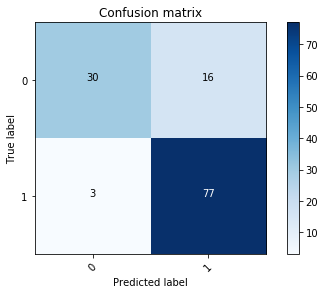

Confusion matrix pour le tag : personnes_agees


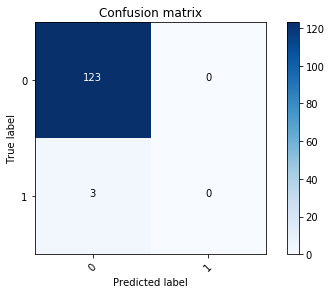

Confusion matrix pour le tag : enfants__adolescents__jeunes_adultes


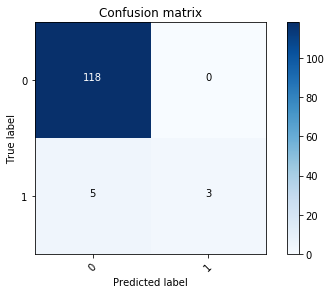

Confusion matrix pour le tag : population_precaire


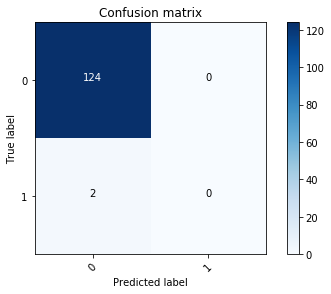

Confusion matrix pour le tag : personnes_handicapees


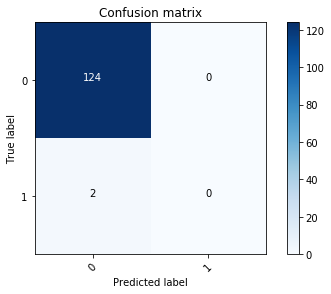

Confusion matrix pour le tag : femmes__accouchement_grossesse____perinatalite


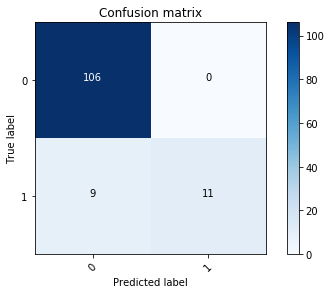

Confusion matrix pour le tag : diabete_et_autres_maladies_endocriniennes


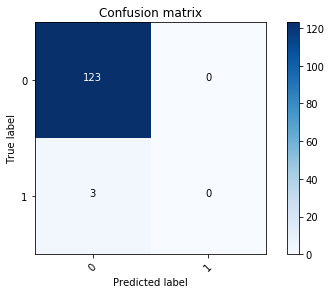

Confusion matrix pour le tag : sante_mentale


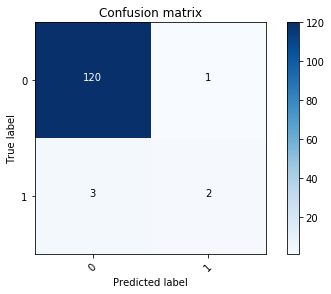

Confusion matrix pour le tag : cancer


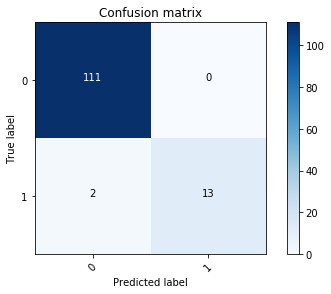

Confusion matrix pour le tag : maladie_de_l_appareil_genito_urinaire__dont_les_insuffisances_renales_chroniques_


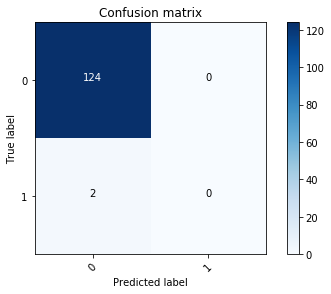

Confusion matrix pour le tag : maladies_cardiovasculaires


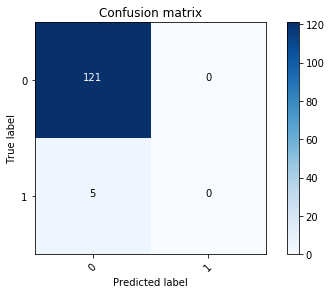

Confusion matrix pour le tag : maladies_neurologiques_ou_degeneratives


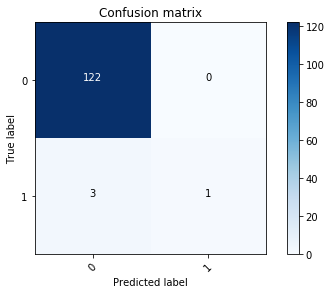

Confusion matrix pour le tag : maladies_respiratoires_


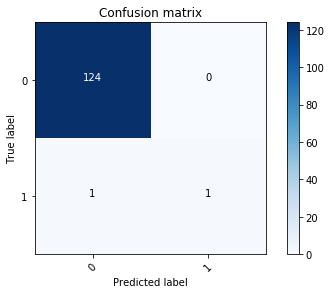

Confusion matrix pour le tag : maladies_de_l_appareil_digestif


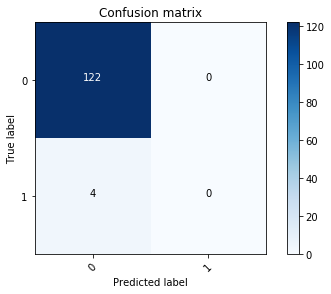

Confusion matrix pour le tag : maladies_infectieuses


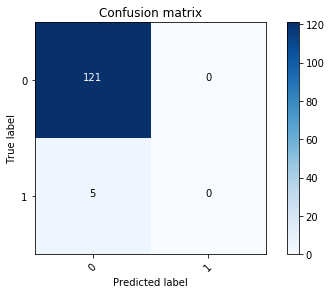

Confusion matrix pour le tag : pathologies_du_systeme_osteo_articulaire


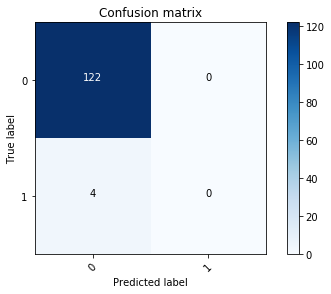

Confusion matrix pour le tag : traumatismes_et_pathologie_accidentelle


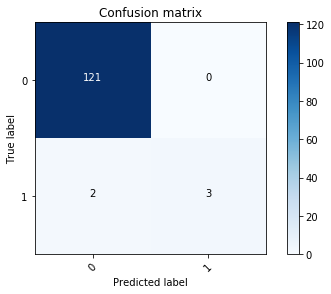

Confusion matrix pour le tag : autres_pathologies


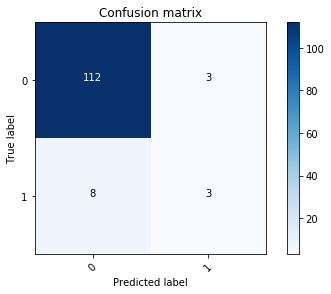

Confusion matrix pour le tag : coordination_continuite


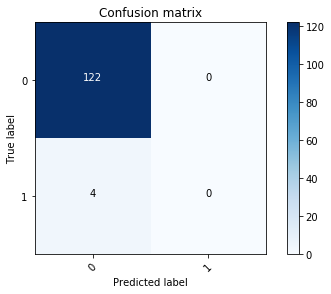

Confusion matrix pour le tag : qualite_et_securite_des_soins


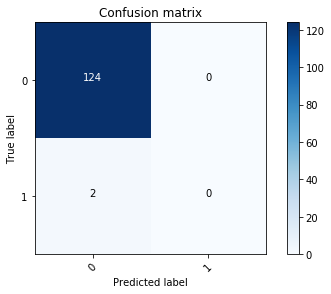

Confusion matrix pour le tag : prevention_depistage


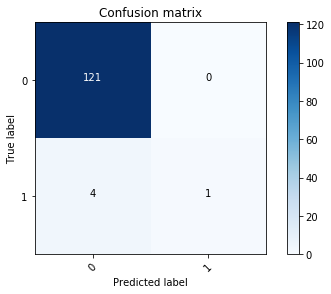

Confusion matrix pour le tag : accessibilite__geographique__financier__autres_


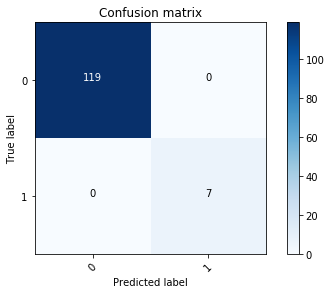

Confusion matrix pour le tag : habitudes_de_vie_et_addictions


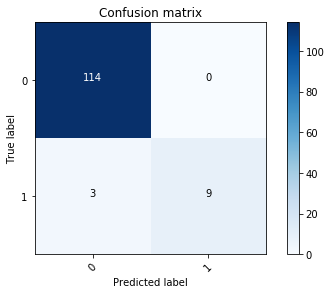

Confusion matrix pour le tag : determinants_environnementaux


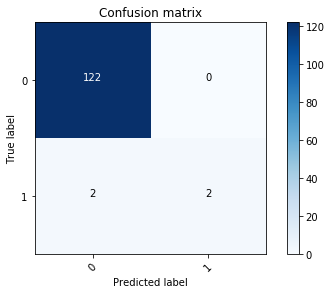

Confusion matrix pour le tag : droits_d_usagers_democratie_sanitaire


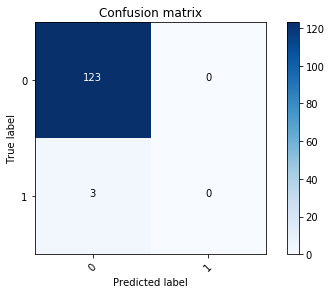

Confusion matrix pour le tag : mesures_d_inegalites_et_de_disparites_territoriales_de_sante


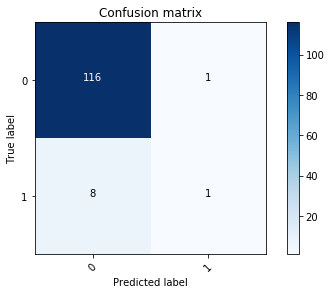

Confusion matrix pour le tag : contexte_demographique_et_socio_economique


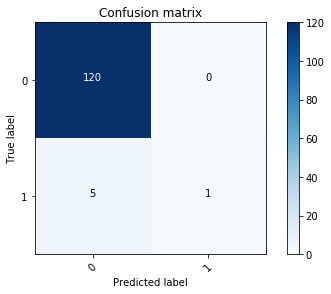

Confusion matrix pour le tag : offre_de_soins


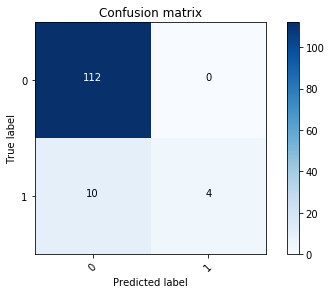

Confusion matrix pour le tag : offre_medico_sociale


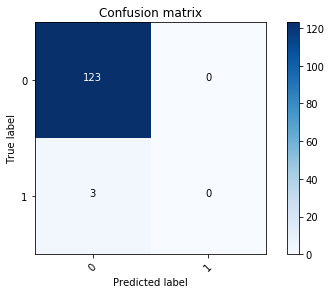

Confusion matrix pour le tag : recours_aux_soins


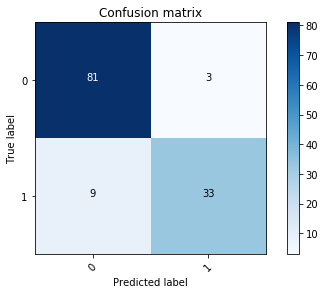

Confusion matrix pour le tag : protection_sociale


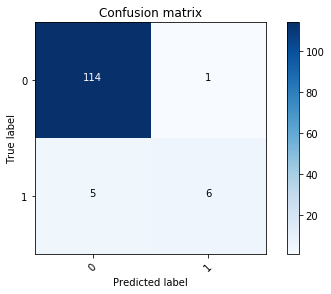

Confusion matrix pour le tag : depenses_de_sante


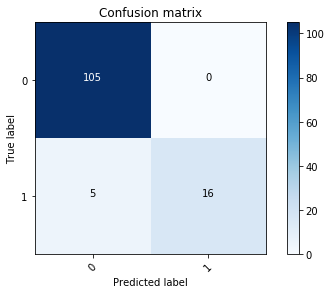

Confusion matrix pour le tag : etat_de_sante


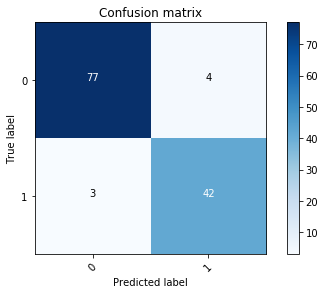

In [40]:
all_confusion_matrix_logistic=matrice_logistic
for i in range(33):
    print('Confusion matrix pour le tag : {0}'.format(base_new.columns[i]))
    matrix=all_confusion_matrix_logistic[i]
    class_names = np.array(['0','1'])
    plot_confusion_matrix(matrix, classes=class_names,
                      title='Confusion matrix')
    plt.show()

On peut considérer que le cas le plus problématique est celui où l'on prédit un 0 alors qu'on aurait du prédire un 1. Par exemple, pour un moteur de recherche, surtout si on a peu de résultats (peu de 1 prédits pour un tag), on préfère avoir un résultat non pertinent (on prédit un 1 alors que c'était un 0), plutôt qu'oublier un résultat (on a un 0 alors qu'on voulait avoir un 1). On va donc regarder le cas le plus problématique : celui où un 0 a été prédit, alors que l'indicateur aurait du sortir avec le tag. Par exemple l'indicateur concernait les personnes âgées, et en filtrant par "personnes âgées", le résultat n'apparaît pas, alors qu'il devrait apparaître.

In [41]:
print("Il y a davantage de vrais 1 prédits comme des 0 que de vrais 1 prédits comme des 1 pour les tags suivants :")
compte_tags_rares=0
compte_tags_mal_predits=0
for i in range(33):
    matrix=all_confusion_matrix_logistic[i]
# syntaxe : matrix[ligne][colonne]
    if (matrix[1][0]>matrix[1][1]):
        compte_tags_mal_predits=compte_tags_mal_predits+1
        if base_new.columns[i] in tags_rares :
            print(base_new.columns[i]+'\033[1m'+' (est un tag rare)'+'\033[0m'+'\n'+'      '+
                  'nombre de 1 dans la base : {0}'.format(tags_effectifs[base_new.columns[i]]))
            compte_tags_rares=compte_tags_rares+1
        else :
            print(base_new.columns[i]+'\n'+'      '+
                  'nombre de 1 dans la base : {0}'.format(tags_effectifs[base_new.columns[i]]))
print("Nombre de tags rares concernés : {0} sur {1} tags rares, et {0} rares sur {2} tags mal prédits".format(compte_tags_rares,
                                                                        len(tags_rares),compte_tags_mal_predits))

Il y a davantage de vrais 1 prédits comme des 0 que de vrais 1 prédits comme des 1 pour les tags suivants :
personnes_agees (est un tag rare)
      nombre de 1 dans la base : 10
enfants__adolescents__jeunes_adultes
      nombre de 1 dans la base : 46
population_precaire (est un tag rare)
      nombre de 1 dans la base : 7
personnes_handicapees (est un tag rare)
      nombre de 1 dans la base : 8
diabete_et_autres_maladies_endocriniennes (est un tag rare)
      nombre de 1 dans la base : 9
sante_mentale
      nombre de 1 dans la base : 41
maladie_de_l_appareil_genito_urinaire__dont_les_insuffisances_renales_chroniques_ (est un tag rare)
      nombre de 1 dans la base : 7
maladies_cardiovasculaires (est un tag rare)
      nombre de 1 dans la base : 16
maladies_neurologiques_ou_degeneratives (est un tag rare)
      nombre de 1 dans la base : 11
maladies_de_l_appareil_digestif (est un tag rare)
      nombre de 1 dans la base : 13
maladies_infectieuses (est un tag rare)
      nombre de 1 da

2) Random forest

In [42]:
all_confusion_matrix=evaluation(clf)[1]

Confusion matrix pour le tag : population_generale


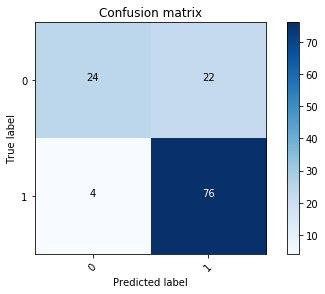

Confusion matrix pour le tag : personnes_agees


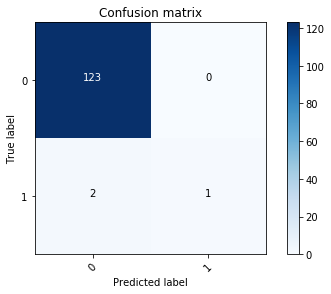

Confusion matrix pour le tag : enfants__adolescents__jeunes_adultes


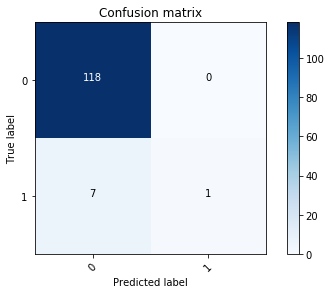

Confusion matrix pour le tag : population_precaire


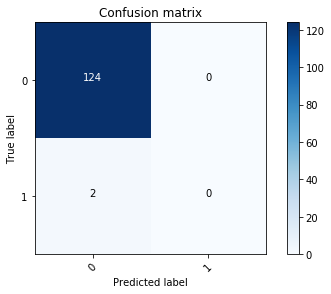

Confusion matrix pour le tag : personnes_handicapees


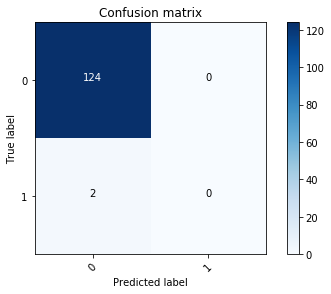

Confusion matrix pour le tag : femmes__accouchement_grossesse____perinatalite


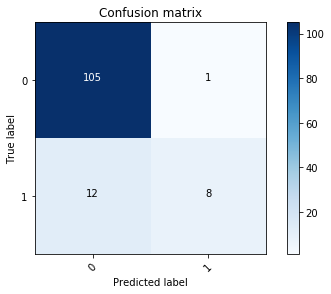

Confusion matrix pour le tag : diabete_et_autres_maladies_endocriniennes


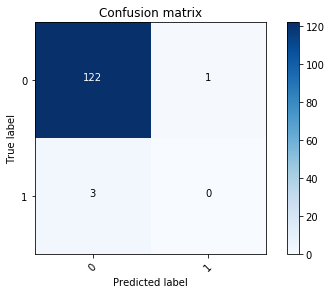

Confusion matrix pour le tag : sante_mentale


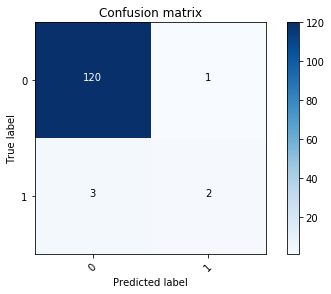

Confusion matrix pour le tag : cancer


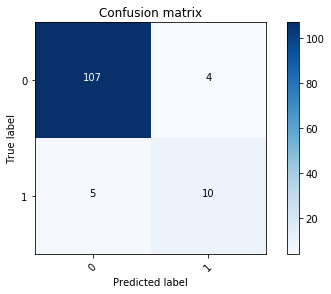

Confusion matrix pour le tag : maladie_de_l_appareil_genito_urinaire__dont_les_insuffisances_renales_chroniques_


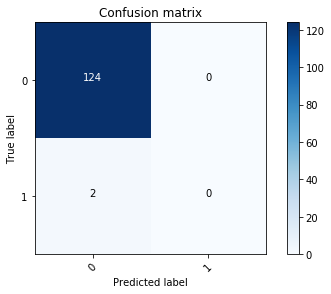

Confusion matrix pour le tag : maladies_cardiovasculaires


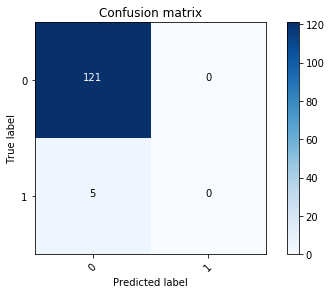

Confusion matrix pour le tag : maladies_neurologiques_ou_degeneratives


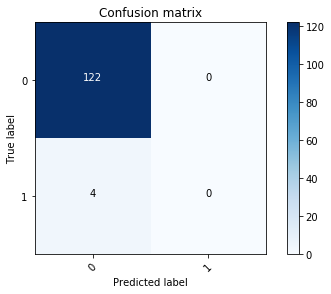

Confusion matrix pour le tag : maladies_respiratoires_


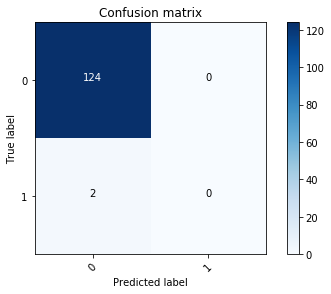

Confusion matrix pour le tag : maladies_de_l_appareil_digestif


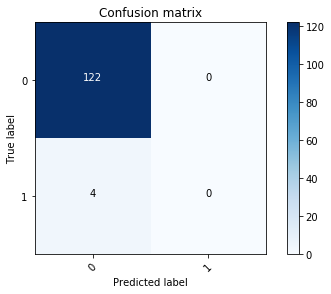

Confusion matrix pour le tag : maladies_infectieuses


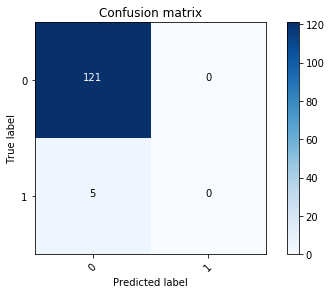

Confusion matrix pour le tag : pathologies_du_systeme_osteo_articulaire


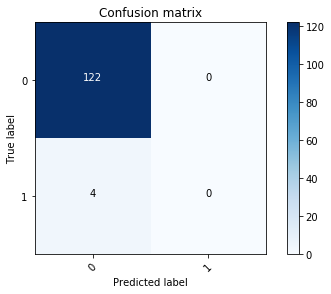

Confusion matrix pour le tag : traumatismes_et_pathologie_accidentelle


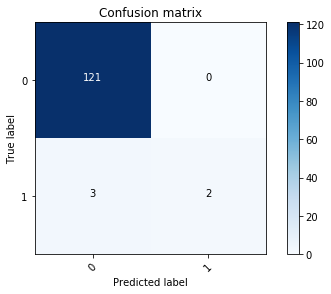

Confusion matrix pour le tag : autres_pathologies


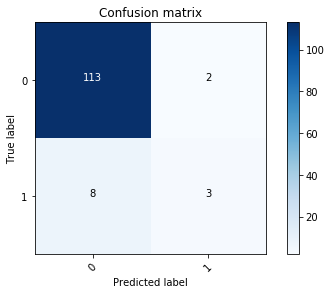

Confusion matrix pour le tag : coordination_continuite


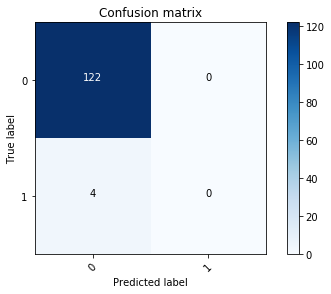

Confusion matrix pour le tag : qualite_et_securite_des_soins


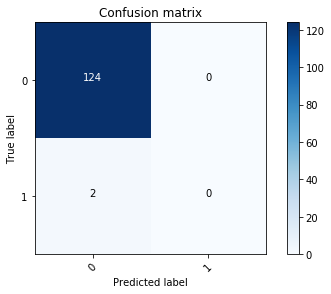

Confusion matrix pour le tag : prevention_depistage


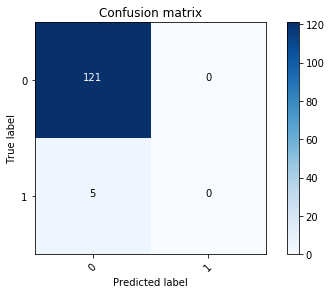

Confusion matrix pour le tag : accessibilite__geographique__financier__autres_


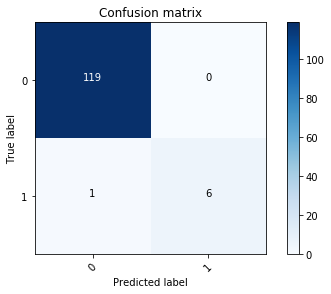

Confusion matrix pour le tag : habitudes_de_vie_et_addictions


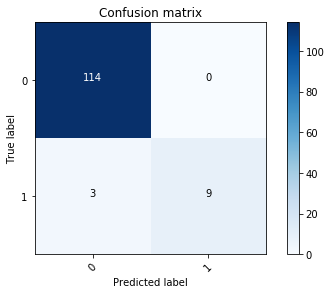

Confusion matrix pour le tag : determinants_environnementaux


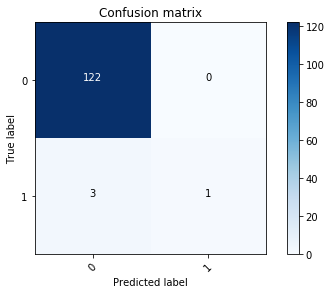

Confusion matrix pour le tag : droits_d_usagers_democratie_sanitaire


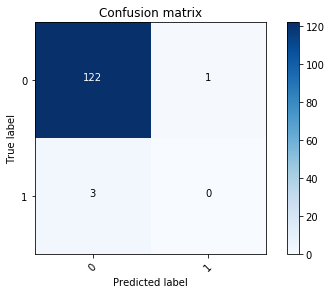

Confusion matrix pour le tag : mesures_d_inegalites_et_de_disparites_territoriales_de_sante


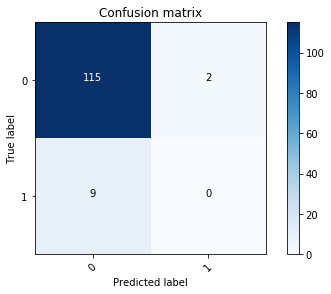

Confusion matrix pour le tag : contexte_demographique_et_socio_economique


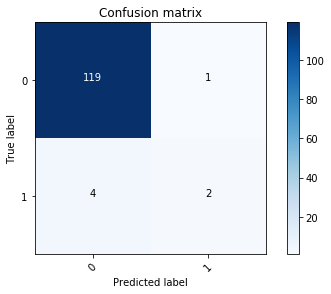

Confusion matrix pour le tag : offre_de_soins


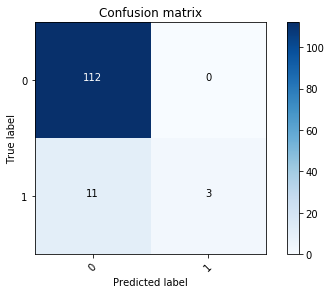

Confusion matrix pour le tag : offre_medico_sociale


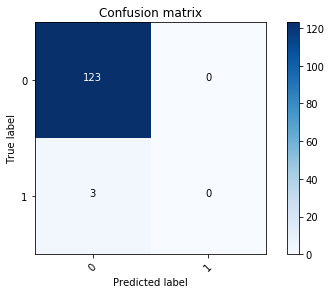

Confusion matrix pour le tag : recours_aux_soins


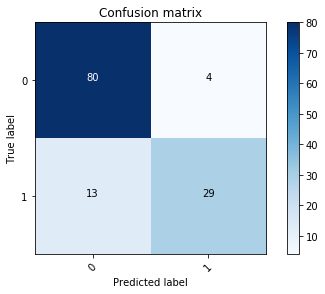

Confusion matrix pour le tag : protection_sociale


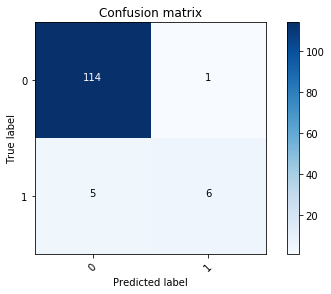

Confusion matrix pour le tag : depenses_de_sante


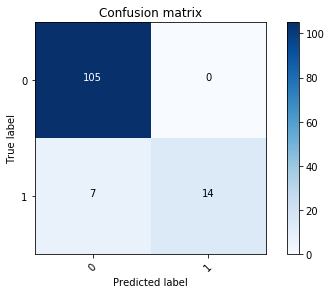

Confusion matrix pour le tag : etat_de_sante


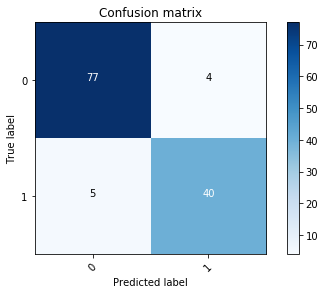

In [43]:
for i in range(33):
    print('Confusion matrix pour le tag : {0}'.format(base_new.columns[i]))
    matrix=all_confusion_matrix[i]
    class_names = np.array(['0','1'])
    plot_confusion_matrix(matrix, classes=class_names,
                      title='Confusion matrix')
    plt.show()


In [44]:
print("Il y a davantage de vrais 1 prédits comme des 0 que de vrais 1 prédits comme des 1 pour les tags suivants :")
compte_tags_rares=0
compte_tags_mal_predits=0
for i in range(33):
    matrix=all_confusion_matrix[i]
# syntaxe : matrix[ligne][colonne]
    if (matrix[1][0]>matrix[1][1]):
        compte_tags_mal_predits=compte_tags_mal_predits+1
        if base_new.columns[i] in tags_rares :
            print(base_new.columns[i]+'\033[1m'+' (est un tag rare)'+'\033[0m'+'\n'+'      '+
                  'nombre de 1 dans la base : {0}'.format(tags_effectifs[base_new.columns[i]]))
            compte_tags_rares=compte_tags_rares+1
        else :
            print(base_new.columns[i]+'\n'+'      '+
                  'nombre de 1 dans la base : {0}'.format(tags_effectifs[base_new.columns[i]]))
print("Nombre de tags rares concernés : {0} sur {1} tags rares, et {0} rares sur {2} tags mal prédits".format(compte_tags_rares,
                                                                        len(tags_rares),compte_tags_mal_predits))

Il y a davantage de vrais 1 prédits comme des 0 que de vrais 1 prédits comme des 1 pour les tags suivants :
personnes_agees (est un tag rare)
      nombre de 1 dans la base : 10
enfants__adolescents__jeunes_adultes
      nombre de 1 dans la base : 46
population_precaire (est un tag rare)
      nombre de 1 dans la base : 7
personnes_handicapees (est un tag rare)
      nombre de 1 dans la base : 8
femmes__accouchement_grossesse____perinatalite
      nombre de 1 dans la base : 109
diabete_et_autres_maladies_endocriniennes (est un tag rare)
      nombre de 1 dans la base : 9
sante_mentale
      nombre de 1 dans la base : 41
maladie_de_l_appareil_genito_urinaire__dont_les_insuffisances_renales_chroniques_ (est un tag rare)
      nombre de 1 dans la base : 7
maladies_cardiovasculaires (est un tag rare)
      nombre de 1 dans la base : 16
maladies_neurologiques_ou_degeneratives (est un tag rare)
      nombre de 1 dans la base : 11
maladies_respiratoires_ (est un tag rare)
      nombre de 1 da

### Conclusion

Les performances des deux modèles demeurent très similaires (et l'ordre de préférence peut s'inverser en fonction du tirage initial de la base de train et de test), y compris pour les tags rares.

On a des difficultés à prédire correctement les 1 quand on en a déjà peu dans la base, et donc dans la base de train en général. En revanche les autres tags sont globalement assez bien prédits. La plupart des tags mal prédits sont des tags rares. Ainsi, il pourrait être raisonnable d'augmenter la taille de la base, mais pas de n'importe quelle manière. <font color=blue>Il serait probablement avisé de compléter la base avec des indicateurs concernés spécifiquement par les tags rares.</font> On voit aussi que parmi les autres tags mal prédits, aucun n'est parmi les plus employés pour référencer les indicateurs, mais certains le sont tout de même souvent (par exemple "protection sociale" a 66 valeurs 1 dans la base, ce n'est donc pas un tag peu utilisé pour le référencement). On pourrait gagner en prédiction pour ces indicateurs en s'assurant qu'ils prennent souvent la valeur 1 dans la base de train, de même qu'on l'avait fait pour les tags rares.